In [ ]:
!nvidia-smi

Tue Dec 16 06:44:29 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA L4                      Off |   00000000:00:03.0 Off |                    0 |
| N/A   36C    P8             11W /   72W |       0MiB /  23034MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
!gdown -qqq 18jwp7X3wFoVTq75Y4ARjXbgFEVPUwOHm
!unzip -qq ocr-documents.zip

In [ ]:
!pip install -Uqqq pip --progress-bar off
!pip install -qqq "mineru-vl-utils[transformers]"==0.1.18 --progress-bar off

In [ ]:
from transformers import AutoProcessor, Qwen2VLForConditionalGeneration
from mineru_vl_utils import MinerUClient
import base64
import io
from PIL import Image, ImageDraw
from IPython.display import display, HTML

In [ ]:
model = Qwen2VLForConditionalGeneration.from_pretrained(
    "opendatalab/MinerU2.5-2509-1.2B", dtype="auto", device_map="auto"
)

processor = AutoProcessor.from_pretrained(
    "opendatalab/MinerU2.5-2509-1.2B", use_fast=True
)

client = MinerUClient(backend="transformers", model=model, processor=processor)

In [ ]:
!nvidia-smi

Tue Dec 16 07:20:31 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA L4                      Off |   00000000:00:03.0 Off |                    0 |
| N/A   49C    P0             28W /   72W |    4687MiB /  23034MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
# @title Compare extraction
def display_extraction(image_path: str, layout_data: list):
    # 1. Define colors for different block types
    color_map = {
        "header": "#FF5733",  # Red-Orange
        "title": "#C70039",  # Dark Red
        "text": "#2E86C1",  # Blue
        "list": "#8E44AD",  # Purple
        "table": "#27AE60",  # Green
        "table_caption": "#16A085",  # Teal
        "figure": "#F39C12",  # Orange
        "default": "#34495E",  # Dark Grey
    }

    try:
        # 2. Load and process the image
        with Image.open(image_path) as img:
            img = img.convert("RGB")
            draw = ImageDraw.Draw(img)
            width, height = img.size

            # Construct the HTML content for the right pane simultaneously
            right_pane_html = ""

            for item in layout_data:
                item_type = item.get("type", "default")
                content = item.get("content")
                bbox = item.get("bbox")  # [x1, y1, x2, y2] normalized

                # --- Draw Bounding Box ---
                if bbox:
                    # Convert normalized coordinates (0-1) to pixel coordinates
                    x1, y1, x2, y2 = bbox
                    rect_coords = [x1 * width, y1 * height, x2 * width, y2 * height]

                    # Get color
                    color = color_map.get(item_type, color_map["default"])

                    # Draw rectangle (outline)
                    draw.rectangle(rect_coords, outline=color, width=3)

                    # Optional: Draw type label slightly above the box
                    # (Simple text drawing, might overlap on dense documents)
                    draw.text(
                        (rect_coords[0], rect_coords[1] - 10), item_type, fill=color
                    )

                # --- Build HTML Content ---
                if content:
                    # Clean escaped dollar signs for display
                    # clean_content = str(content).replace(r"\$", "$")
                    clean_content = (
                        str(content)
                        .replace(r"\(", "")
                        .replace(r"\)", "")
                        .replace(r"\%", "%")
                    )

                    # clean_content = content

                    if item_type == "title":
                        right_pane_html += f"<h2>{clean_content}</h2>"
                    elif item_type == "header":
                        right_pane_html += (
                            f"<h4 style='margin-bottom:0;'>{clean_content}</h4>"
                        )
                    elif item_type == "table":
                        # Tables usually come as raw HTML in these models
                        right_pane_html += f"<div style='overflow-x:auto; margin: 10px 0;'>{clean_content}</div>"
                    elif item_type == "table_caption":
                        right_pane_html += f"<p><strong>{clean_content}</strong></p>"
                    else:
                        # Standard text
                        right_pane_html += f"<p>{clean_content}</p>"

            # 3. Convert processed PIL image to Base64 string
            buffered = io.BytesIO()
            img.save(buffered, format="PNG")
            img_str = base64.b64encode(buffered.getvalue()).decode("utf-8")
            image_uri = f"data:image/png;base64,{img_str}"

    except FileNotFoundError:
        print(f"Error: Image file not found at '{image_path}'")
        return
    except Exception as e:
        print(f"An error occurred: {e}")
        return

    # 4. Construct HTML Template
    html_template = f"""
    <style>
        .container {{
            display: flex;
            align-items: flex-start;
            width: 100%;
            border: 1px solid #e0e0e0;
            border-radius: 8px;
            overflow: hidden;
            font-family: 'Segoe UI', Helvetica, Arial, sans-serif;
        }}
        .pane {{
            flex: 1;
            padding: 15px;
            max-width: 50%;
            box-sizing: border-box;
        }}
        .pane-left {{
            background-color: #f9f9f9;
            border-right: 1px solid #e0e0e0;
            text-align: center;
        }}
        .pane img {{
            width: 100%;
            height: auto;
            object-fit: contain;
            box-shadow: 0 2px 4px rgba(0,0,0,0.1);
        }}
        .markdown-body {{
            font-size: 14px;
            line-height: 1.6;
            height: 80vh; /* Fixed height with scroll for text pane */
            overflow-y: auto;
        }}
        /* Table Styling */
        table {{
            border-collapse: collapse;
            width: 100%;
            font-size: 12px;
        }}
        th, td {{
            border: 1px solid #ddd;
            padding: 6px;
            text-align: left;
        }}
        th {{
            font-weight: bold;
        }}
    </style>

    <div class="container">
      <!-- Left Pane: Image with Bounding Boxes -->
      <div class="pane pane-left">
        <img src="{image_uri}">
      </div>

      <!-- Right Pane: Extracted Text/HTML -->
      <div class="pane markdown-body">
        {right_pane_html}
      </div>
    </div>
    """

    display(HTML(html_template))

In [ ]:
img_path = "nvidia-first-page.jpg"
extracted_blocks = client.two_step_extract(Image.open(img_path))

Predict: 100%|██████████| 13/13 [00:34<00:00,  2.63s/it]


In [ ]:
extracted_blocks

[{'type': 'header',
  'bbox': [0.061, 0.039, 0.142, 0.054],
  'angle': 0,
  'content': 'NVIDIA'},
 {'type': 'title',
  'bbox': [0.086, 0.07, 0.895, 0.123],
  'angle': 0,
  'content': 'NVIDIA Announces Financial Results for First Quarter Fiscal 2026'},
 {'type': 'text',
  'bbox': [0.104, 0.141, 0.747, 0.158],
  'angle': 0,
  'content': 'Revenue of $44.1 billion, up 12% from Q4 and up 69% from a year ago'},
 {'type': 'text',
  'bbox': [0.104, 0.16, 0.849, 0.177],
  'angle': 0,
  'content': '- Data Center revenue of $39.1 billion, up 10% from Q4 and up 73% from a year ago'},
 {'type': 'list',
  'bbox': [0.104, 0.141, 0.849, 0.177],
  'angle': 0,
  'content': None},
 {'type': 'text',
  'bbox': [0.084, 0.188, 0.946, 0.218],
  'angle': 0,
  'content': 'NVIDIA (NASDAQ: NVIDIA) today reported revenue for the first quarter ended April 27, 2025, of $44.1 billion, up 12% from the previous quarter and up 69% from a year ago.'},
 {'type': 'text',
  'bbox': [0.084, 0.227, 0.946, 0.3],
  'angle': 0,



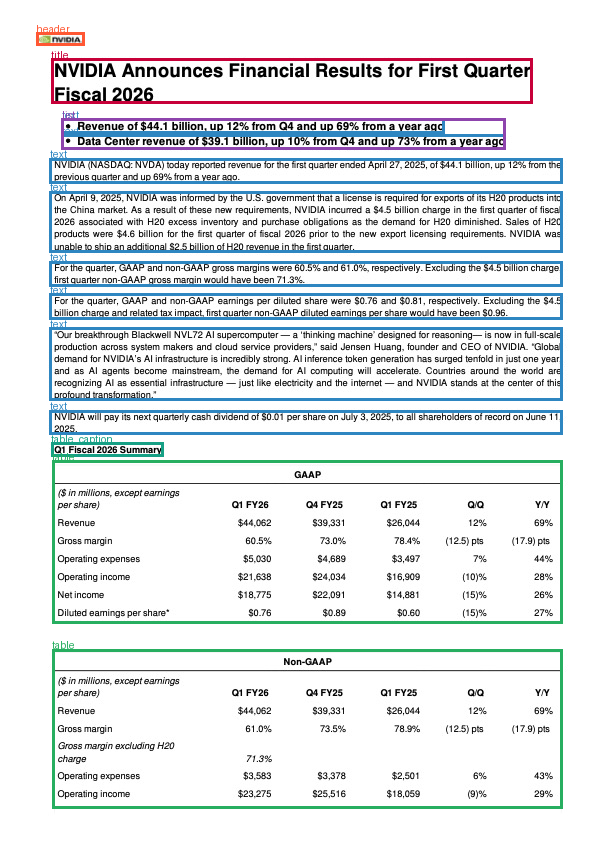

In [ ]:
display_extraction(img_path, extracted_blocks)

In [ ]:
img_path = "nvidia-inner-page.jpg"
extracted_blocks = client.two_step_extract(Image.open(img_path))

Predict: 100%|██████████| 5/5 [00:18<00:00,  3.79s/it]



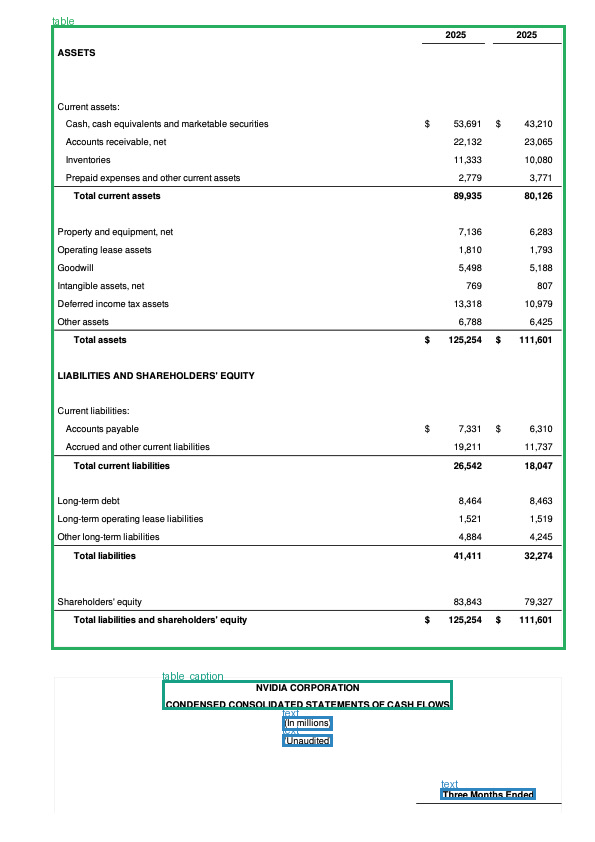

In [ ]:
display_extraction(img_path, extracted_blocks)

In [ ]:
img_path = "page.jpg"
extracted_blocks = client.two_step_extract(Image.open(img_path))

Predict: 100%|██████████| 11/11 [00:43<00:00,  3.91s/it]



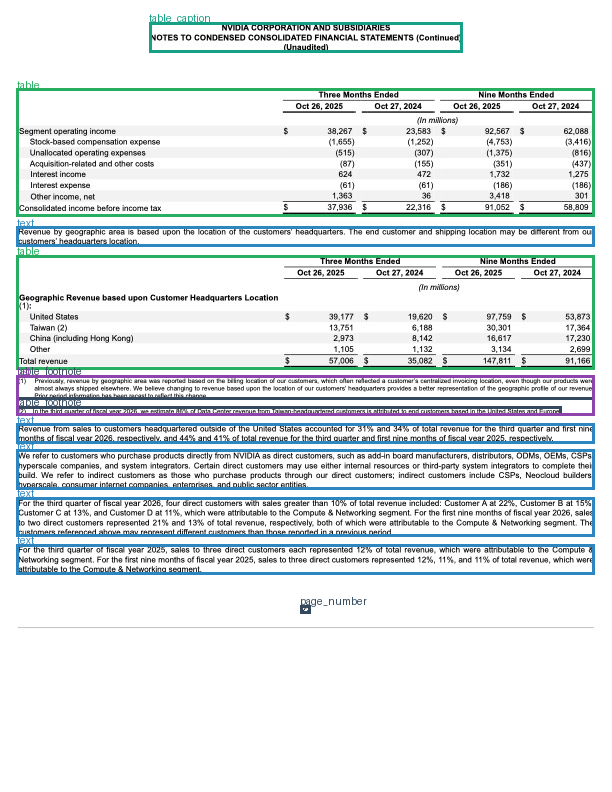

In [ ]:
display_extraction(img_path, extracted_blocks)

In [ ]:
img_path = "receipt.jpg"
extracted_blocks = client.two_step_extract(Image.open(img_path))

Predict: 100%|██████████| 20/20 [00:09<00:00,  2.15it/s]



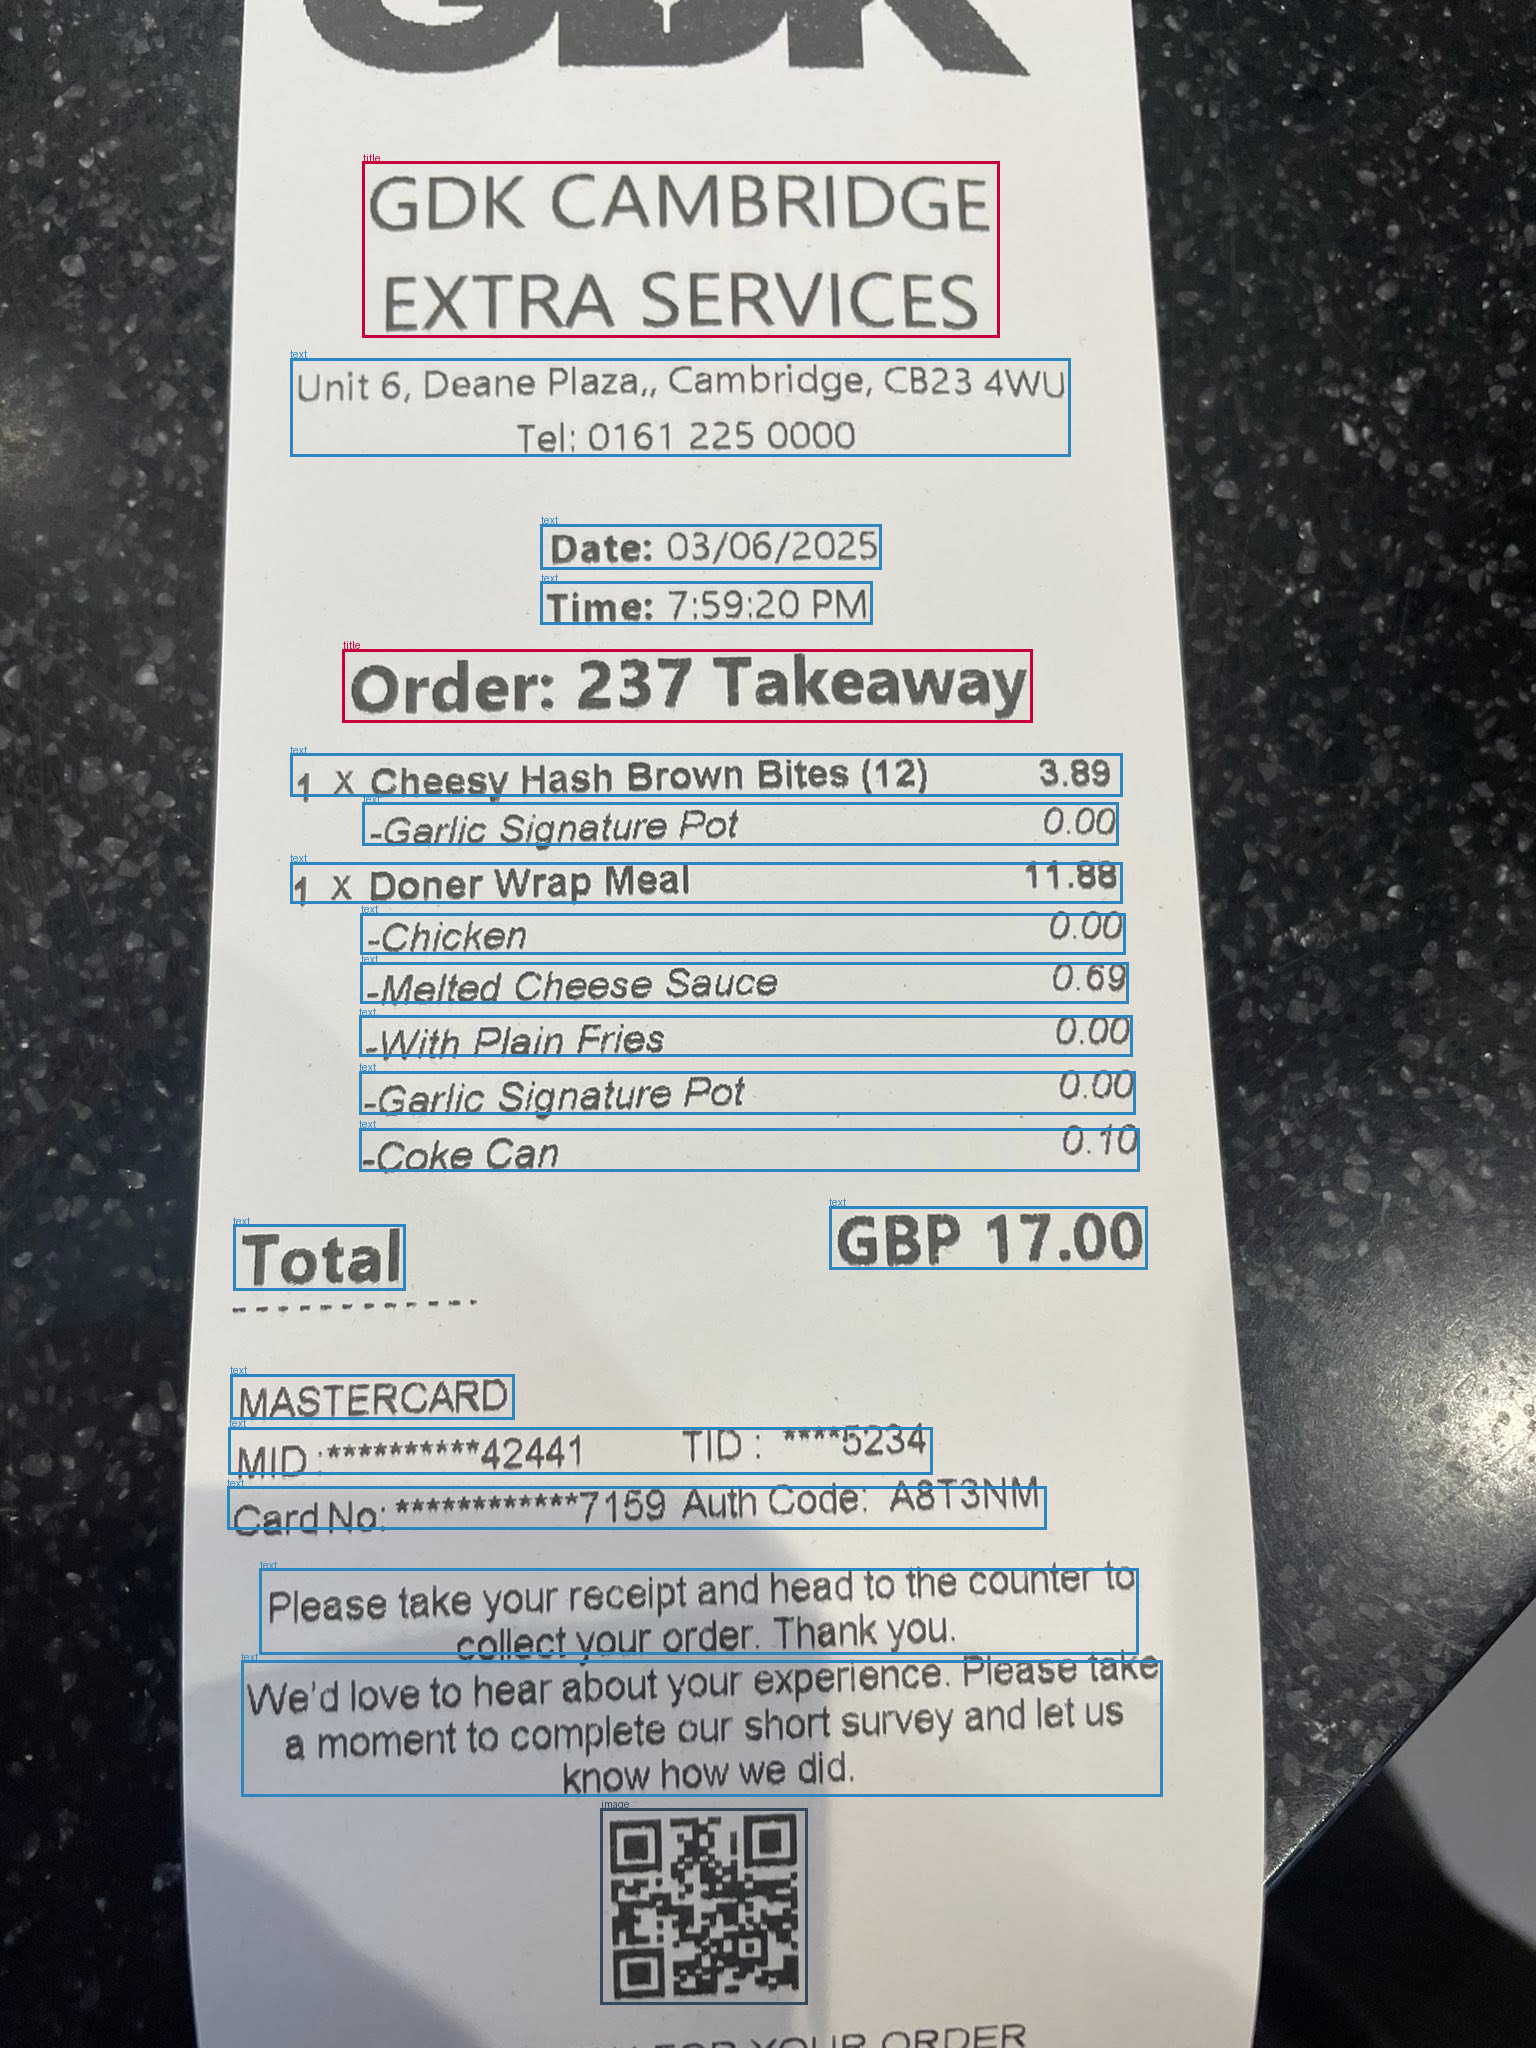

In [ ]:
display_extraction(img_path, extracted_blocks)

In [ ]:
img_path = "id-card.png"
extracted_blocks = client.two_step_extract(Image.open(img_path))

Predict: 100%|██████████| 26/26 [00:06<00:00,  3.83it/s]



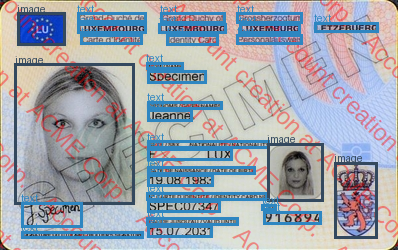

In [ ]:
display_extraction(img_path, extracted_blocks)


References:

- Model: https://huggingface.co/opendatalab/MinerU2.5-2509-1.2B
- Want to become better AI Engineer: https://mlexpert.io/